In [1]:
#Libraries
import numpy as np 
from numpy import newaxis
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU , Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

In [2]:
# load sinwave data (Time Series)
sin_data = pd.read_csv('sinwave\sinewave.csv')

In [3]:
# Sequnce window to prepare input sequences
seq_window = 80
data = sin_data["sinewave"].values.reshape(-1, 1)

In [4]:
# Prepare and Normaliza sequences and return train and test data according to split
def preprcess_data(data, seq_window, test_train_split = .80):
    
    
    scaler = MinMaxScaler(feature_range=(0,1))
    sequences = []
    
    for i in range(data.size - seq_window):
        sequences.append(scaler.fit_transform(data[i: i + seq_window]))
        
    sequences = np.array(sequences)
    
    train_rows = round(test_train_split * sequences.shape[0])
    train = sequences[:train_rows]
    test = sequences[train_rows:]
    
    np.random.shuffle(train)
    
    x_train = train[: , :-1]
    y_train = train[:, -1]
    
    x_test = test[: , :-1]
    y_test = test[:, -1]
    
    
    return x_train, y_train , x_test, y_test

In [6]:
#Predict sequence using trained model
def predict_sequence(model, data, seq_window):
    
    frame = data[0]
    prediction = []
    for i in range(len(data)):
        
        #shift windows to 1 , append new prediction to end and re-run prediction on new frame
        prediction.append(model.predict(frame[newaxis,:,:])[0,0])
        frame = np.insert(frame, (seq_window-1), prediction[-1], axis=0)
        frame = frame[1:]
    return prediction

In [7]:
# Plot Predicted and True Values
def plot_true_predicted_data(y_test, prediction):

    fig = plt.figure(facecolor='white', figsize=(8,6)) 
    plt.plot(y_test, label='True Data') 
    plt.plot(prediction, label='Prediction') 
    plt.legend() 
    plt.show() 

In [8]:
# Preprocess and split data
x_train, y_train , x_test, y_test =  preprcess_data(data, seq_window, .80)

In [8]:
#LSTM Model

lstm_model = Sequential(name="LSTM")

lstm_model.add(LSTM(units = 100, return_sequences=True, input_shape=(x_train.shape[1],1), activation="linear"))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50, return_sequences=True, activation="linear"))
lstm_model.add(Dropout(0.2))


lstm_model.add(LSTM(units=50, activation="linear"))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units= 1, activation="linear"))
lstm_model.compile(loss='mse', optimizer='adam')

print (lstm_model.summary())

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 79, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 79, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 79, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51     

In [9]:
#Train LSTM Model
his_lstm  =lstm_model.fit(x_train, y_train, batch_size=256, epochs=10, validation_data = (x_test, y_test), verbose = True)

Epoch 1/10
16/16 [==============================] - 8s 310ms/step - loss: 0.1771 - val_loss: 0.0306
Epoch 2/10
16/16 [==============================] - 4s 272ms/step - loss: 0.0220 - val_loss: 0.0039
Epoch 3/10
16/16 [==============================] - 4s 269ms/step - loss: 0.0082 - val_loss: 9.4208e-04
Epoch 4/10
16/16 [==============================] - 5s 298ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 5/10
16/16 [==============================] - 5s 315ms/step - loss: 0.0048 - val_loss: 2.4978e-04
Epoch 6/10
16/16 [==============================] - 5s 307ms/step - loss: 0.0041 - val_loss: 4.7897e-04
Epoch 7/10
16/16 [==============================] - 5s 312ms/step - loss: 0.0038 - val_loss: 4.0082e-05
Epoch 8/10
16/16 [==============================] - 5s 300ms/step - loss: 0.0037 - val_loss: 5.4675e-05
Epoch 9/10
16/16 [==============================] - 5s 309ms/step - loss: 0.0036 - val_loss: 4.7303e-04
Epoch 10/10
16/16 [==============================] - 5s 312ms/step - loss: 0

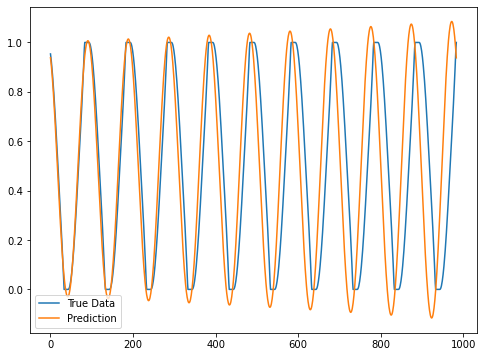

In [10]:
#Predict and Plot LSTM Predictions
prediction_lstm =  predict_sequence(lstm_model, x_test , seq_window)
plot_true_predicted_data(y_test,prediction_lstm )